# American Sign Language (ASL) Translator

## Imports

In [ ]:
!pip install mediapipe
!pip install tensorflow
!pip install kaggle
!kaggle datasets download -d grassknoted/asl-alphabet

In [ ]:
import patoolib
patoolib.extract_archive("asl-alphabet.zip")

In [1]:
import tensorflow as tf
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense

## Preprocessing

In [2]:
path_Train = "C:/HackWesTX/asl_alphabet_train/asl_alphabet_train"
data_dir = Path(path_Train)
batch_size = 100
img_height = 48
img_width = 48

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

global class_names
class_names = train_ds.class_names
print(class_names)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [3]:
#defining the model

from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# number of possible label values
nb_classes = 29

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(nb_classes)
])

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

## Model Training and Validation

In [4]:
history = model.fit(train_ds,validation_data=val_ds,epochs = 50)

Epoch 1/50
696/696 [==============================] - 222s 317ms/step - loss: 2.9187 - accuracy: 0.1926 - val_loss: 2.3550 - val_accuracy: 0.3211
Epoch 2/50
696/696 [==============================] - 114s 164ms/step - loss: 1.9753 - accuracy: 0.4225 - val_loss: 1.6915 - val_accuracy: 0.4900
Epoch 3/50
696/696 [==============================] - 110s 158ms/step - loss: 1.4734 - accuracy: 0.5600 - val_loss: 1.3136 - val_accuracy: 0.5981
Epoch 4/50
696/696 [==============================] - 113s 162ms/step - loss: 1.1791 - accuracy: 0.6428 - val_loss: 1.0750 - val_accuracy: 0.6716
Epoch 5/50
696/696 [==============================] - 115s 165ms/step - loss: 0.9806 - accuracy: 0.7039 - val_loss: 0.9106 - val_accuracy: 0.7293
Epoch 6/50
696/696 [==============================] - 109s 157ms/step - loss: 0.8421 - accuracy: 0.7473 - val_loss: 0.7943 - val_accuracy: 0.7593
Epoch 7/50
696/696 [==============================] - 113s 162ms/step - loss: 0.7341 - accuracy: 0.7786 - val_loss: 0.7191 -

In [5]:
model.save("asl.model")

INFO:tensorflow:Assets written to: asl.model\assets


## Training Results

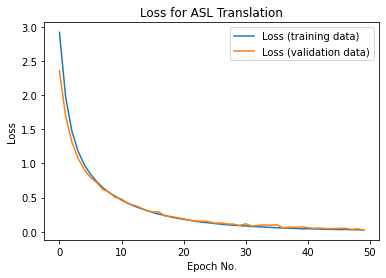

In [6]:
# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for ASL Translation')
plt.ylabel('Loss')
plt.xlabel('Epoch No.')
plt.legend(loc="upper right")
plt.show()

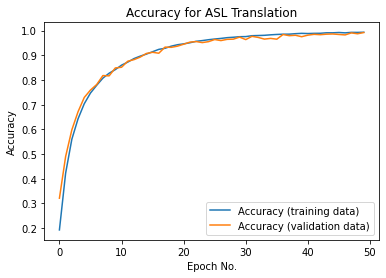

In [7]:
# Plot history: Accuracy
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy for ASL Translation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch No.')
plt.legend(loc="lower right")
plt.show()

## Predictions from Camera Input

In [9]:
from tensorflow.keras.models import load_model
model = load_model('asl.model')

In [12]:
cap = cv2.VideoCapture(1)
while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Webcam is being used by another program!")
        break
    
    
    
    
    inp = cv2.resize(frame,(48,48))
    rgbImg = cv2.cvtColor(inp,cv2.COLOR_BGR2RGB)
    
    input_tensor = tf.convert_to_tensor(rgbImg, dtype=tf.float32)
    input_tensor = tf.expand_dims(input_tensor, 0)
    predictionID = model.predict(input_tensor).argmax(axis=1)
    #print(str(int(predictionID)))
    classPrediction = class_names[int(predictionID)]
    frame = np.fliplr(frame).copy()
    cv2.putText(frame,str(classPrediction), (50, 50),cv2.FONT_HERSHEY_SIMPLEX,1, (255,0,0),2,cv2.LINE_AA)
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break